---
## Data Collection Is Effective

At this point, it's clear I've been able to collect the right data from Chicago. We're going to assume the data is clean & correct for now. I may return to review later.

## Training and Testing

At this point it would be nice to create the training and testing data. We'll train on data from 2015 to 2021 (because I want to capture the peak from COVID). In the testing data, it would be ideal to accurately predict the protest activity in mid-2024. 

Let's pull the full data set, split it, and then see how it looks to continue and understand how we would build this model.

---

In [107]:
# type the following to install the required packages into terminal
# conda activate civil_unrest
# gcloud init
# gcloud auth application-default login

# Some other packages that may be needed
# %pip install db-dtypes


In [108]:
# Import the necessary module
from google.cloud import bigquery
import pandas as pd
from matplotlib import pyplot as plt
import folium
from folium.plugins import HeatMap
import numpy as np
from matplotlib import colors
from geopy.distance import geodesic


In [109]:
# Initialize BigQuery client with the project ID
client = bigquery.Client(project="civil-unrest-predictor")

query = """
SELECT
    SQLDATE,
    EventCode,
    ActionGeo_FullName,
    ActionGeo_Lat,
    ActionGeo_Long,
    AvgTone
FROM
    `gdelt-bq.full.events`
WHERE
    EventCode IN ('145', '1451', '1452', '1453', '1454')
    AND ActionGeo_FullName LIKE '%Chicago%'
    AND CAST(SQLDATE AS STRING) >= '20150101'
ORDER BY
    SQLDATE DESC;
"""

# Execute the updated query
query_job = client.query(query)

# Convert results to a DataFrame
data = query_job.result().to_dataframe()

KeyboardInterrupt: 

In [110]:
data

SQLDATE EventCode                              ActionGeo_FullName  \
0    2024-12-11       145                Chicago, Illinois, United States   
1    2024-12-11       145                Chicago, Illinois, United States   
2    2024-12-06       145                Chicago, Illinois, United States   
3    2024-12-02       145  University Of Chicago, Illinois, United States   
4    2024-12-02       145                Chicago, Illinois, United States   
...         ...       ...                                             ...   
3344 2015-01-19       145                Chicago, Illinois, United States   
3345 2015-01-19       145                Chicago, Illinois, United States   
3346 2015-01-19       145                Chicago, Illinois, United States   
3347 2015-01-19       145                Chicago, Illinois, United States   
3348 2015-01-08       145                Chicago, Illinois, United States   

      ActionGeo_Lat  ActionGeo_Long   AvgTone  
0           41.8500        -87.6501 -4.147465  
1           41.8500        -87.6501 -4.147465  
2           41.8500        -87.6501  1.066667  
3           41.7898        -87.5998 -0.843289  
4           41.8500        -87.6501 -7.840083  
...             ...             ...       ...  
3344        41.8500        -87.6501  2.494577  
3345        41.8500        -87.6501  2.857143  
3346        41.8500        -87.6501  2.494577  
3347        41.8500        -87.6501  2.494577  
3348        41.8500        -87.6501  2.007772  

[3349 rows x 6 columns]

In [111]:
# Convert SQLDATE to datetime format using .loc
data.loc[:, 'SQLDATE'] = pd.to_datetime(data['SQLDATE'], format='%Y%m%d')

reindex_data = data.copy()
reindex_data = reindex_data.groupby('SQLDATE').size().reindex(pd.date_range(start=reindex_data['SQLDATE'].min(), 
                                                                          end=reindex_data['SQLDATE'].max()), 
                                                                          fill_value=0).reset_index()
reindex_data.columns = ['SQLDATE', 'Number of Events']
reindex_data

SQLDATE  Number of Events
0    2015-01-08                 1
1    2015-01-09                 0
2    2015-01-10                 0
3    2015-01-11                 0
4    2015-01-12                 0
...         ...               ...
3621 2024-12-07                 0
3622 2024-12-08                 0
3623 2024-12-09                 0
3624 2024-12-10                 0
3625 2024-12-11                 2

[3626 rows x 2 columns]

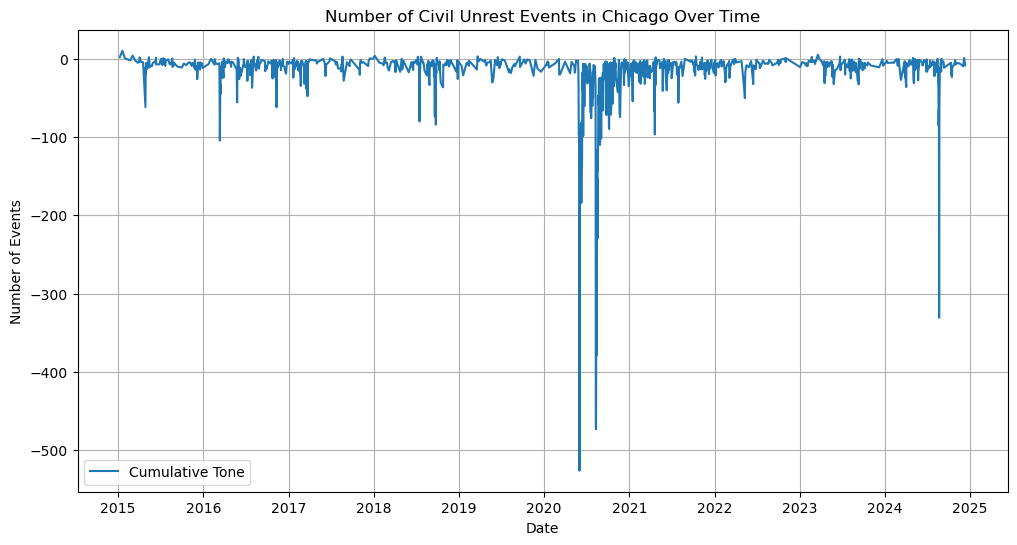

In [114]:
def cuml_tone(dates):
    cuml_tone = {}

    row = 0
    for date in data['SQLDATE']:
        if date in cuml_tone:
            cuml_tone[date] = cuml_tone[date] + data.iloc[row]['AvgTone']
        else:
            cuml_tone[date] = data.iloc[row]['AvgTone']
        row+=1

    #cuml_tone

    daily_cuml_tone = []
    for date in data['SQLDATE']:
        daily_cuml_tone.append(cuml_tone[date])

    return daily_cuml_tone

# Let's plot all of the points
plt.figure(figsize=(12, 6))
plt.plot(data['SQLDATE'], cuml_tone(data['SQLDATE']), label='Cumulative Tone')
plt.title('Number of Civil Unrest Events in Chicago Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.legend()
plt.grid(True)
plt.show()

In [115]:
# To get the visualization of the data
# %pip install folium

In [116]:
# Create a base map centered around Chicago
m = folium.Map(location=[41.8500, -87.6501], zoom_start=12)

# Normalize AvgTone to a range between 0 and 1 for color mapping
norm = plt.Normalize(vmin=data['AvgTone'].min(), vmax=data['AvgTone'].max())

# Add points to the map with gradient color
for _, row in data.iterrows():
    color = plt.cm.RdYlBu_r(norm(row['AvgTone']))  # Use a reversed colormap (RdYlBu_r)
    folium.CircleMarker(
        location=[row['ActionGeo_Lat'], row['ActionGeo_Long']],
        radius=10,  # Increase the radius to make dots larger
        popup=f"Date: {row['SQLDATE']}\nAvgTone: {row['AvgTone']}",
        color=colors.rgb2hex(color[:3]),  # Convert RGBA to hex
        fill=True,
        fill_color=colors.rgb2hex(color[:3])
    ).add_to(m)

# Display the map
m

In [ ]:
# More packages to install!
#%pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [118]:
# Define the center of the Chicago Loop
chicago_loop_center = (41.8811, -87.6297)

# Function to calculate distance from the center of the Chicago Loop
def is_within_one_mile(row):
    event_location = (row['ActionGeo_Lat'], row['ActionGeo_Long'])
    distance = geodesic(chicago_loop_center, event_location).miles
    return distance <= 1

# Apply the function to filter the data
filtered_data = data[data.apply(is_within_one_mile, axis=1)]

filtered_data

SQLDATE EventCode                                 ActionGeo_FullName  \
255  2024-05-29       145  Art Institute Of Chicago, Illinois, United States   
341  2024-02-20       145  Art Institute Of Chicago, Illinois, United States   
373  2023-09-15       145  Art Institute Of Chicago, Illinois, United States   
374  2023-09-14       145  Art Institute Of Chicago, Illinois, United States   
456  2023-05-08       145             Chicago River, Illinois, United States   
...         ...       ...                                                ...   
2329 2020-06-01       145              Chicago Loop, Illinois, United States   
2354 2020-05-31       145             Chicago River, Illinois, United States   
2361 2020-05-31       145             Chicago River, Illinois, United States   
2792 2018-03-07       145  School Of The Art Institute Of Chicago, Illino...   
3205 2016-03-12       145              Chicago Loop, Illinois, United States   

      ActionGeo_Lat  ActionGeo_Long   AvgTone  
255         41.8795        -87.6223 -1.477105  
341         41.8795        -87.6223 -0.286670  
373         41.8795        -87.6223 -1.963534  
374         41.8795        -87.6223 -1.963534  
456         41.8867        -87.6373 -4.545455  
...             ...             ...       ...  
2329        41.8811        -87.6298 -6.817213  
2354        41.8867        -87.6373 -3.030303  
2361        41.8867        -87.6373 -6.977679  
2792        41.8789        -87.6217 -2.269861  
3205        41.8811        -87.6298 -2.366864  

[65 rows x 6 columns]

In [120]:
filtered_data


SQLDATE EventCode                                 ActionGeo_FullName  \
255  2024-05-29       145  Art Institute Of Chicago, Illinois, United States   
341  2024-02-20       145  Art Institute Of Chicago, Illinois, United States   
373  2023-09-15       145  Art Institute Of Chicago, Illinois, United States   
374  2023-09-14       145  Art Institute Of Chicago, Illinois, United States   
456  2023-05-08       145             Chicago River, Illinois, United States   
...         ...       ...                                                ...   
2329 2020-06-01       145              Chicago Loop, Illinois, United States   
2354 2020-05-31       145             Chicago River, Illinois, United States   
2361 2020-05-31       145             Chicago River, Illinois, United States   
2792 2018-03-07       145  School Of The Art Institute Of Chicago, Illino...   
3205 2016-03-12       145              Chicago Loop, Illinois, United States   

      ActionGeo_Lat  ActionGeo_Long   AvgTone  
255         41.8795        -87.6223 -1.477105  
341         41.8795        -87.6223 -0.286670  
373         41.8795        -87.6223 -1.963534  
374         41.8795        -87.6223 -1.963534  
456         41.8867        -87.6373 -4.545455  
...             ...             ...       ...  
2329        41.8811        -87.6298 -6.817213  
2354        41.8867        -87.6373 -3.030303  
2361        41.8867        -87.6373 -6.977679  
2792        41.8789        -87.6217 -2.269861  
3205        41.8811        -87.6298 -2.366864  

[65 rows x 6 columns]

In [121]:
data

SQLDATE EventCode                              ActionGeo_FullName  \
0    2024-12-11       145                Chicago, Illinois, United States   
1    2024-12-11       145                Chicago, Illinois, United States   
2    2024-12-06       145                Chicago, Illinois, United States   
3    2024-12-02       145  University Of Chicago, Illinois, United States   
4    2024-12-02       145                Chicago, Illinois, United States   
...         ...       ...                                             ...   
3344 2015-01-19       145                Chicago, Illinois, United States   
3345 2015-01-19       145                Chicago, Illinois, United States   
3346 2015-01-19       145                Chicago, Illinois, United States   
3347 2015-01-19       145                Chicago, Illinois, United States   
3348 2015-01-08       145                Chicago, Illinois, United States   

      ActionGeo_Lat  ActionGeo_Long   AvgTone  
0           41.8500        -87.6501 -4.147465  
1           41.8500        -87.6501 -4.147465  
2           41.8500        -87.6501  1.066667  
3           41.7898        -87.5998 -0.843289  
4           41.8500        -87.6501 -7.840083  
...             ...             ...       ...  
3344        41.8500        -87.6501  2.494577  
3345        41.8500        -87.6501  2.857143  
3346        41.8500        -87.6501  2.494577  
3347        41.8500        -87.6501  2.494577  
3348        41.8500        -87.6501  2.007772  

[3349 rows x 6 columns]

In [130]:
cuml_tone(filtered_data['SQLDATE'])

[-8.29493087557604,
 -8.29493087557604,
 1.06666666666667,
 -9.52666072657402,
 -9.52666072657402,
 -9.52666072657402,
 -6.06767794632438,
 -5.40265035677879,
 -7.37951807228916,
 -1.57273918741808,
 -1.57273918741808,
 -6.5625,
 -11.52398871119472,
 -11.52398871119472,
 -23.26860584925103,
 -23.26860584925103,
 -23.26860584925103,
 -10.8552631578947,
 -20.90177359726707,
 -20.90177359726707,
 -20.90177359726707,
 -19.950424462555958,
 -19.950424462555958,
 -19.950424462555958,
 -19.950424462555958,
 -4.95049504950496,
 -11.46131805157594,
 -11.46131805157594,
 -4.07938257993385,
 -3.0712612914018,
 -2.50250250250251,
 -0.10319917440661,
 -16.25090224357948,
 -16.25090224357948,
 -16.25090224357948,
 -16.25090224357948,
 -16.25090224357948,
 -13.62962962962964,
 -13.62962962962964,
 -13.62962962962964,
 -13.62962962962964,
 -4.739336492891,
 -15.258776914354861,
 -15.258776914354861,
 -15.258776914354861,
 -11.402518676230638,
 -11.402518676230638,
 -11.402518676230638,
 -11.9551574302

In [124]:
filtered_data['SQLDATE']

255    2024-05-29
341    2024-02-20
373    2023-09-15
374    2023-09-14
456    2023-05-08
          ...    
2329   2020-06-01
2354   2020-05-31
2361   2020-05-31
2792   2018-03-07
3205   2016-03-12
Name: SQLDATE, Length: 65, dtype: datetime64[ns]

In [129]:
cuml_tone(filtered_data['SQLDATE'])

[-8.29493087557604,
 -8.29493087557604,
 1.06666666666667,
 -9.52666072657402,
 -9.52666072657402,
 -9.52666072657402,
 -6.06767794632438,
 -5.40265035677879,
 -7.37951807228916,
 -1.57273918741808,
 -1.57273918741808,
 -6.5625,
 -11.52398871119472,
 -11.52398871119472,
 -23.26860584925103,
 -23.26860584925103,
 -23.26860584925103,
 -10.8552631578947,
 -20.90177359726707,
 -20.90177359726707,
 -20.90177359726707,
 -19.950424462555958,
 -19.950424462555958,
 -19.950424462555958,
 -19.950424462555958,
 -4.95049504950496,
 -11.46131805157594,
 -11.46131805157594,
 -4.07938257993385,
 -3.0712612914018,
 -2.50250250250251,
 -0.10319917440661,
 -16.25090224357948,
 -16.25090224357948,
 -16.25090224357948,
 -16.25090224357948,
 -16.25090224357948,
 -13.62962962962964,
 -13.62962962962964,
 -13.62962962962964,
 -13.62962962962964,
 -4.739336492891,
 -15.258776914354861,
 -15.258776914354861,
 -15.258776914354861,
 -11.402518676230638,
 -11.402518676230638,
 -11.402518676230638,
 -11.9551574302

In [125]:
data['SQLDATE']


0      2024-12-11
1      2024-12-11
2      2024-12-06
3      2024-12-02
4      2024-12-02
          ...    
3344   2015-01-19
3345   2015-01-19
3346   2015-01-19
3347   2015-01-19
3348   2015-01-08
Name: SQLDATE, Length: 3349, dtype: datetime64[ns]

ValueError: x and y must have same first dimension, but have shapes (65,) and (3349,)

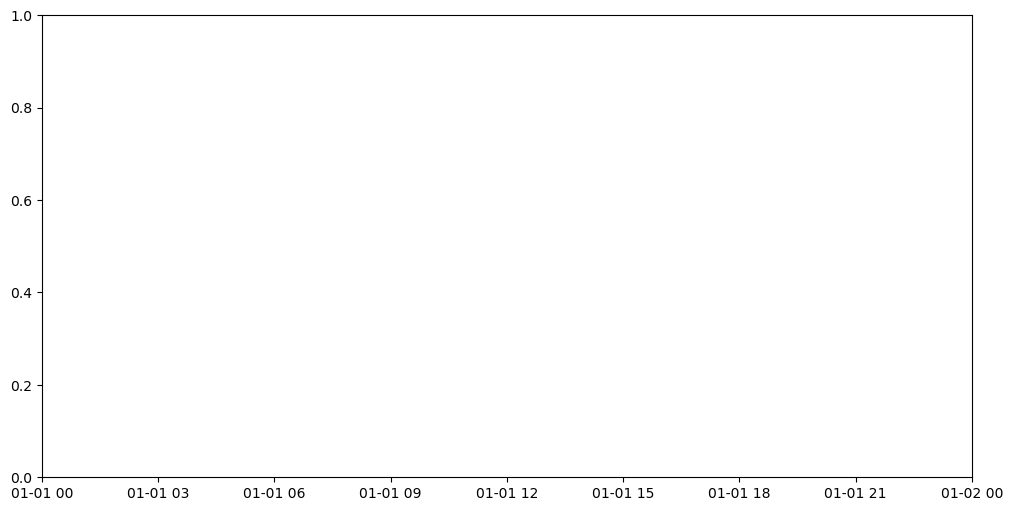

In [ ]:
# Let's plot all of the points
plt.figure(figsize=(12, 6))
plt.plot(filtered_data['SQLDATE'], cuml_tone(filtered_data['SQLDATE']), label='Cumulative Tone')
plt.title('Number of Civil Unrest Events in Chicago Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
# Create a base map centered around Chicago
m = folium.Map(location=list(chicago_loop_center), zoom_start=15)

# Normalize AvgTone to a range between 0 and 1 for color mapping
norm = plt.Normalize(vmin=filtered_data['AvgTone'].min(), vmax=filtered_data['AvgTone'].max())

# Add points to the map with gradient color
for _, row in filtered_data.iterrows():
    color = plt.cm.RdYlBu_r(norm(row['AvgTone']))  # Use a reversed colormap (RdYlBu_r)
    folium.CircleMarker(
        location=[row['ActionGeo_Lat'], row['ActionGeo_Long']],
        radius=10,  # Increase the radius to make dots larger
        popup=f"Date: {row['SQLDATE']}\nAvgTone: {row['AvgTone']}",
        color=colors.rgb2hex(color[:3]),  # Convert RGBA to hex
        fill=True,
        fill_color=colors.rgb2hex(color[:3])
    ).add_to(m)

# Display the map
m

In [58]:
# Convert SQLDATE to datetime format using .loc
filtered_data.loc[:, 'SQLDATE'] = pd.to_datetime(filtered_data['SQLDATE'], format='%Y%m%d')

train_data = filtered_data[filtered_data['SQLDATE'] < '2021-01-01']
train_data = train_data.groupby('SQLDATE').size().reindex(pd.date_range(start=train_data['SQLDATE'].min(), end=train_data['SQLDATE'].max()), fill_value=0).reset_index()
train_data.columns = ['SQLDATE', 'Number of Events']

test_data = filtered_data[filtered_data['SQLDATE'] >= '2021-01-01']
test_data = test_data.groupby('SQLDATE').size().reindex(pd.date_range(start=test_data['SQLDATE'].min(), end=test_data['SQLDATE'].max()), fill_value=0).reset_index()
test_data.columns = ['SQLDATE', 'Number of Events']

In [59]:
train_data.columns

Index(['SQLDATE', 'Number of Events'], dtype='object')

In [60]:
test_data.columns

Index(['SQLDATE', 'Number of Events'], dtype='object')

In [61]:
# Save the results to CSV files
train_data.to_csv("chicago_violent_protests_train.csv", index=True)
print("Training data saved to 'chicago_violent_protests_train.csv'")

test_data.to_csv("chicago_violent_protests_test.csv", index=True)
print("Testing data saved to 'chicago_violent_protests_test.csv'")

Training data saved to 'chicago_violent_protests_train.csv'
Testing data saved to 'chicago_violent_protests_test.csv'


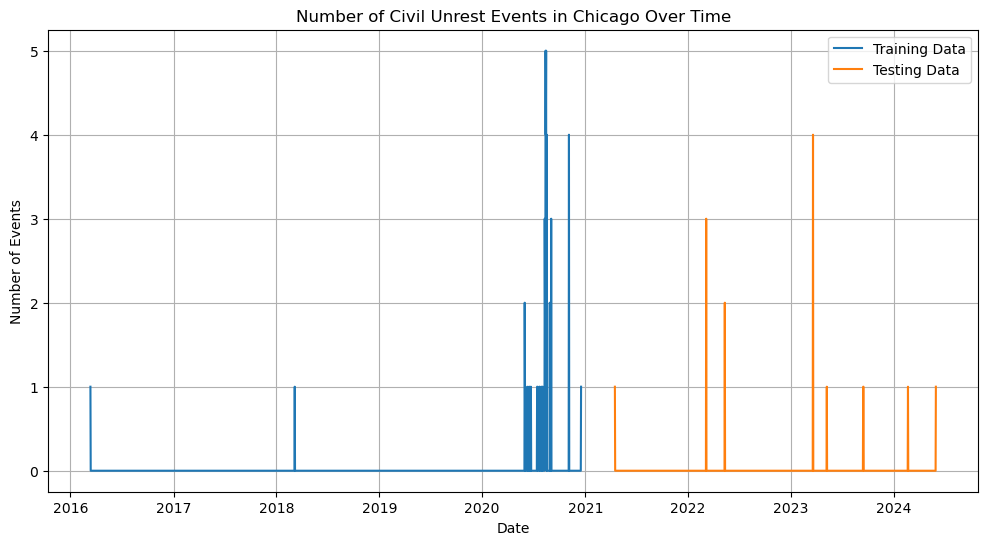

In [62]:
# Plot the number of events over time for training and testing data
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(train_data['SQLDATE'], train_data['Number of Events'], label='Training Data')

# Plot testing data
plt.plot(test_data['SQLDATE'], test_data['Number of Events'], label='Testing Data')

plt.title('Number of Civil Unrest Events in Chicago Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.legend()
plt.grid(True)
plt.show()

I'm curious. If we express this as a product of tones, what would that look like?

---

## Comparisons with Research

### Let's see if these events show up in the data set

2015: Protests Following the Release of Laquan McDonald Video

In November 2015, the release of dashcam footage showing the police shooting of Laquan McDonald sparked widespread protests. Demonstrators blocked major intersections and disrupted shopping areas, leading to multiple arrests and instances of property damage. 

2020: George Floyd Protests

The death of George Floyd in May 2020 led to nationwide protests, with Chicago experiencing significant unrest. On May 31, the city recorded its deadliest day in at least 30 years, with 18 homicides within a 24-hour period. The violence coincided with protests that included rioting and looting, overwhelming the city's emergency response systems. 

2021: Protests Following the Killing of Adam Toledo

In April 2021, the police shooting of 13-year-old Adam Toledo resulted in protests throughout Chicago. While many demonstrations remained peaceful, there were instances of clashes between protesters and police, leading to arrests and injuries. 

2024: Democratic National Convention Protests

During the Democratic National Convention in August 2024, Chicago faced significant disruptions from pro-Palestinian protesters. These demonstrations led to confrontations with law enforcement and caused substantial disturbances in the city. 

These events highlight periods where protests in Chicago escalated into dangerous situations, impacting both public safety and city operations.

---

/var/folders/bh/bs5kljm140s_4k8bp_hzf8n00000gn/T/ipykernel_7749/1269483440.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['SQLDATE'] = pd.to_datetime(filtered_data['SQLDATE'], format='%Y%m%d')


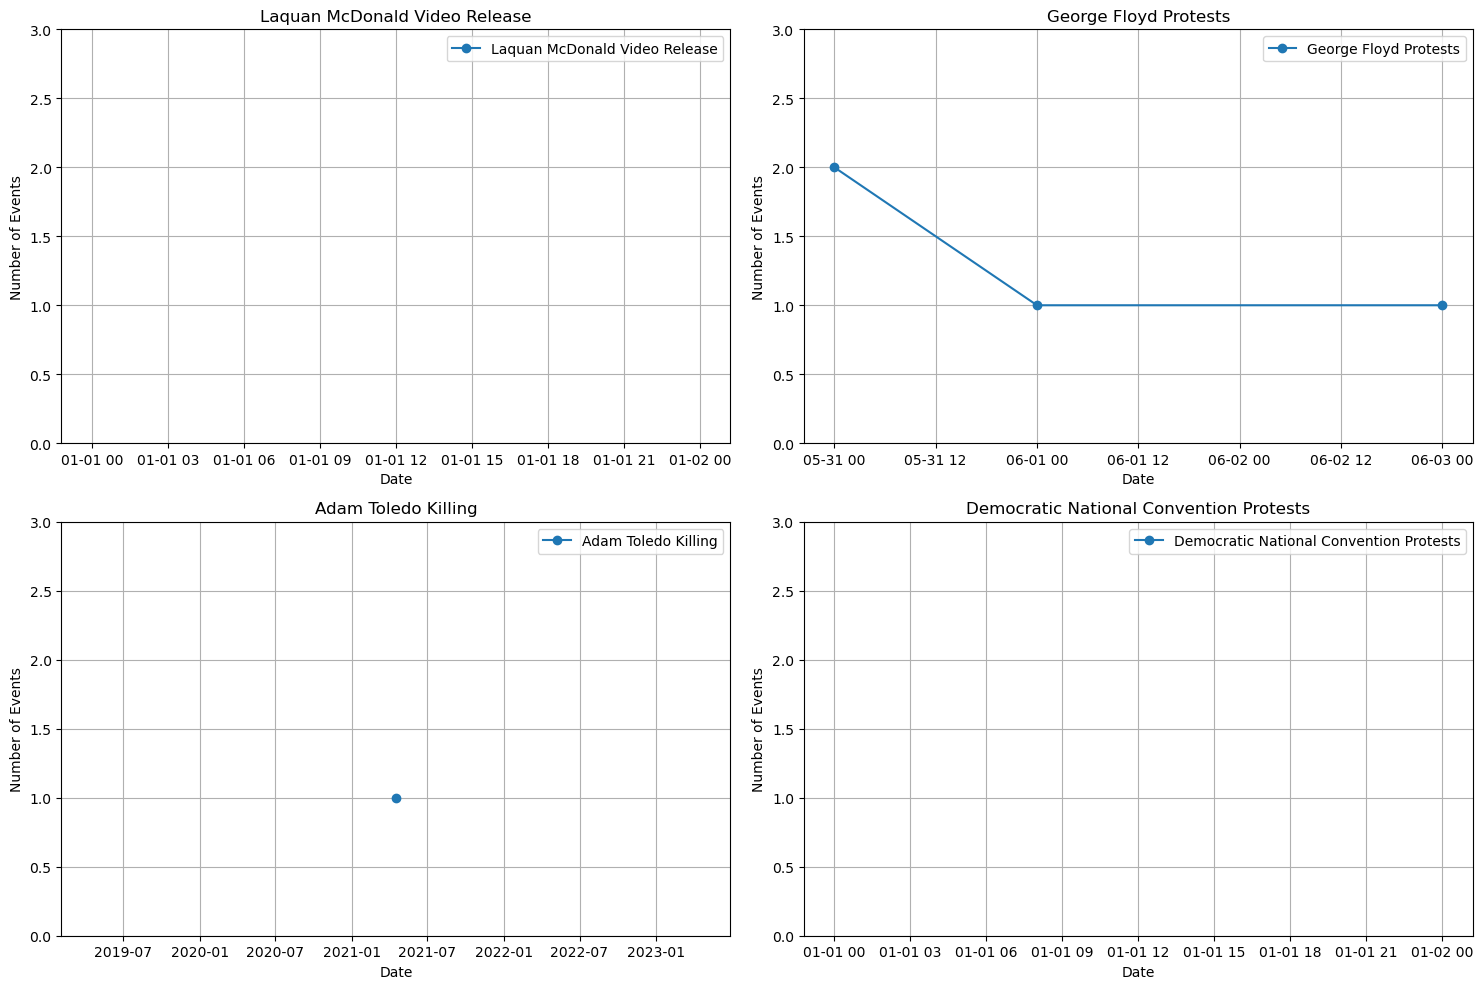

In [65]:
# Define the specific events and their dates
events = {
    "Laquan McDonald Video Release": "2015-11-24",
    "George Floyd Protests": "2020-05-31",
    "Adam Toledo Killing": "2021-04-13",
    "Democratic National Convention Protests": "2024-08-24"
}

# Convert event dates to datetime
events = {event: pd.to_datetime(date) for event, date in events.items()}

# Convert SQLDATE to datetime format
filtered_data['SQLDATE'] = pd.to_datetime(filtered_data['SQLDATE'], format='%Y%m%d')

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# Determine the y-axis limits based on the maximum number of events in any window
max_events = 0
for event, date in events.items():
    window_data = filtered_data[(filtered_data['SQLDATE'] >= date - pd.Timedelta(days=5)) & (filtered_data['SQLDATE'] <= date + pd.Timedelta(days=5))]
    max_events = max(max_events, window_data.groupby('SQLDATE').size().max())

for ax, (event, date) in zip(axes, events.items()):
    # Filter data for the 10-day window around the event
    window_data = filtered_data[(filtered_data['SQLDATE'] >= date - pd.Timedelta(days=5)) & (filtered_data['SQLDATE'] <= date + pd.Timedelta(days=5))]
    
    # Group data and ensure alignment
    grouped_data = window_data.groupby('SQLDATE').size()
    ax.plot(grouped_data.index, grouped_data.values, marker='o', label=event)
    ax.set_title(event)
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Events')
    ax.set_ylim(0, max_events + 1)  # Set the same y-axis limits for all subplots
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

---

It looks like half of these events were captured. With the George Floyd and DNC events being more significant, I feel confident this data is still good; however, it'll be important to ensure the data we pulled actually is associated with the personal risk of an individual in Chicago. Seeing as the major protests of George Floyd and the DNC protests were far more signficant in nature than other protest, then I feel this is acceptable. 

We should return to see if we can naunce this further.

---